# Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')
basedir = '/content/drive/My Drive/PSDA Group 4/Data/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Install Dependencies

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as sm
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Task 3

**Übungsblatt 1**

Aufgabe 3

Folgende Teilaufgaben beschreiben die Fragestellungen. Untersuchen Sie die Art der Variablen und
die Verteilung der Zielvariablen. Gegebenenfalls ist eine Datenvorverarbeitung nötig. Nennen Sie die
möglichen Methoden. Wählen Sie eine Methode aus und begründen Sie Ihre Auswahl. Bitte
separieren Sie die Datensätze mit 80%:20% = Training:Test und führen Sie die Methode ohne
Parameteroptimierung aus. Vergleichen Sie die Ergebnisse mit den vorgegebenen Methoden.

## a.)

a.)
Der Datensatz employment_08_09.xlsx beinhaltet die sozioökonomischen Daten der
Arbeitskräfte in den USA im April 2008 und Angaben, ob sie im April 2009 weiterhin angestellt
sind. Alle Befragten waren im April 2008 angestellt. Sagen Sie basierend auf den 2008er
Informationen vorher, welche Arbeitskraft 2009 arbeitslos wird. Haben ältere Arbeitskräfte
ein höheres Risiko für Arbeitslosigkeit während der Finanzkrise 2008-2009?
Baseline: Häufigste Klasse, lineare Regression.

### Read Data

In [0]:
#read dataframe
df = pd.read_csv(basedir+'employment_08_09.csv')

### Pre-processing

We first want to inspect the data and have a closer look at the different variables.

In [0]:
#inspect data
df.head()
#df.info()

,age,race,earnwke,employed,unemployed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
0,53,1,NaN,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,39,1,NaN,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,41,1,500.0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,27,1,520.0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
4,29,3,615.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


We can see that that we have two continous variables (age & earnwke) and the rest are binary categorical variables

In [0]:
#convert columns to categorical
for col in df.columns:
  if col not in ['earnwke','age']:
    df[col] = df[col].astype('category')

By checking for missing values, we identify that the variale earnwke has some missing values. We impute them with the average value.

In [0]:
#check for missing values
df.isnull().sum()
df['earnwke'] = df.earnwke.fillna(848)

Since the other variables are all binary, there is no need to further pre-process the data at this point.

### Data Partitioning

In [0]:
#output variable is unemployed, since we want to predict who will be unemployed in 2009
y = df['employed']
X = df.drop(columns = ['unemployed','employed'])

# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

### Baseline Model

We take the most common class as our predictor for the baseline

In [0]:
df.groupby('employed').count()

,age,race,earnwke,unemployed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
employed,,,,,,,,,,,,,,,,,,,,
0,674,674,674,674,674,674,674,674,674,674,674,674,674,674,674,674,674,674,674,674
1,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738


The most common class for "employed" is 1. That shows us that most of the workers are employed in 2009. Hence, we take 1 as the predicted value for our baseline model. Let's see the scores if we predict 1 for all workers.

Our test dataset has 1083 entries. We check the scores in case we would predict 0 for all 1083 test entries

In [0]:
len(y_test) #1083
y_pred = [1] * 1083
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [0]:
# Check scores for classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.88      1.00      0.94       958

    accuracy                           0.88      1083
   macro avg       0.44      0.50      0.47      1083
weighted avg       0.78      0.88      0.83      1083



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that with this method we already predict 88% of the outcomes correctly. However, this is not a good approach because we don't identify people that might be unemployed in 2009, we just assume that all workers will be employed in 2009.

### Logistic Regression

**Logistic regression**
Since we deal here with a classification problem, which is a problem in which we want to predict a certain class (in this case 1 or 0) for our outcome variable, we choose to use a logistic regression model.

Since we deal with a highly unbalanced dataset, it is useful to adjust the threshold for the regression.

In [0]:
log = LogisticRegression()
log.fit(X_train,y_train)
#THRESHOLD = 0.5
#y_pred = np.where(log.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
y_pred = log.predict(X_test)

# Check scores for classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.88      1.00      0.94       958

    accuracy                           0.88      1083
   macro avg       0.44      0.50      0.47      1083
weighted avg       0.78      0.88      0.83      1083



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Testing out several other models showed us that using the most common class as a predictor is the most suitable one given this dataset. No other model that we tested improved the scores. For instance, the logistic regression model also predicts all workers in 2009 to be employed.

### Effects on old workers

Haben ältere Arbeitskräfte ein höheres Risiko für Arbeitslosigkeit während der Finanzkrise 2008-2009?

In [0]:
print(df.age.mean())
print(df[df.employed == 0].age.mean())
print(df[df.employed == 1].age.mean())

42.602365114560236
41.362017804154306
42.77880962431406


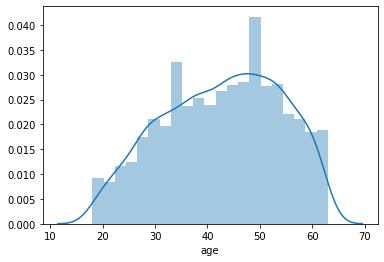

In [0]:
sns.distplot(df[df.employed == 1].age)

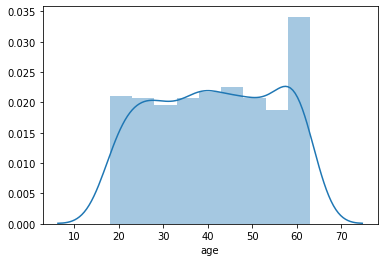

In [0]:
sns.distplot(df[df.employed == 0].age)

While the mean age of unemployed workers is lower (41.4) than the overall mean age (42.6), by insepcting the distribution plots for both groups, we can see that for the unemployed group there is a significant spike in the number of unemployed people around 60 years. This could indeed indicate that old people are more affected by the financial crisis.

## b.)

b.)
Der Datensatz Growth.xlsx besteht aus dem Wachstum (Änderung des realen
Bruttoinlandsprodukts in Prozent) von 65 Ländern und Indikatoren, die theoretisch das
Wachstum erklären könnten. Schätzen Sie das Wachstum der Länder im Test-Datensatz,
basierend auf den Indikatoren.
3
Baseline: Das durchschnittliche Wachstum aller Länder.
Hinweis: Es gibt möglicherweise Dateninkonsistenz.

### Read Data

In [0]:
df = pd.read_csv(basedir+'Growth.csv')
df.head()

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,India,1.915168,0,765.999817,0.140502,1.45,0.133333,0.866667
1,Argentina,0.617645,0,4462.001465,0.156623,4.99,0.933333,1.933333
2,Japan,4.304759,0,2953.999512,0.157703,6.71,0.000000,0.200000
3,Brazil,2.930097,0,1783.999878,0.160405,2.89,0.100000,0.100000
4,United States,1.712265,0,9895.003906,0.160815,8.66,0.000000,0.433333


We can see that none of the countries have oil, so we don't need to consider that variable. Also the name of the country is not important for us.

In [0]:
df = df.drop(columns = ['oil','country_name'])

### Inspect Correlations

Let's first explore the correlation of the variables a little further by using a pairplot

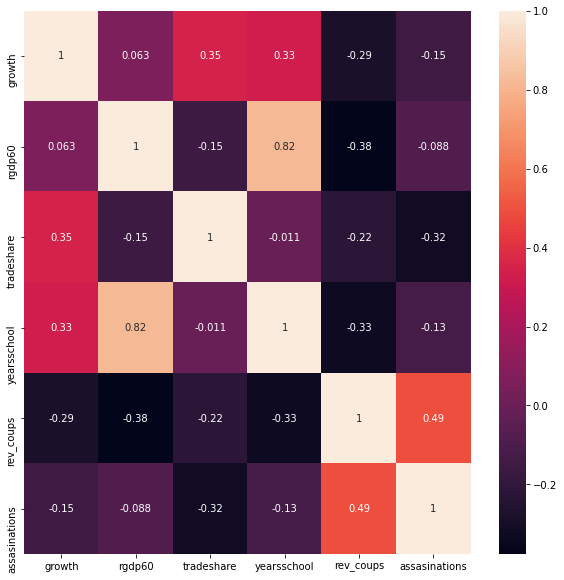

In [0]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

We can see that growth has the highest absolute correlation with tradeshare, yearsschool and rev_coups and rgdb60 and yearsschool are highly correlated.

### Inspect distributions

Let's have a look at the distribution of our output variable.

1.9427153967384616


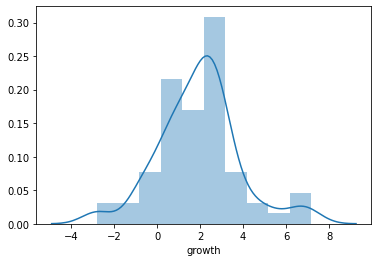

In [0]:
sns.distplot(df.growth)
print(df.growth.mean())

Growth seems to be relatively normally distributed with a slight skew towards higher values. The mean is 1.94

### Data Partitioning

In [0]:
X = df.drop(columns = ['growth'])
y = df['growth']

# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

### Baseline Model

We will first examine the performance of the baseline model, which is taking the average growth of all countries as the predicted value.

In [0]:
len(y_test) #13
y_pred = [df.growth.mean()] * 13
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}) 

# Check accuracy scores for regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.2417508141739648
Mean Squared Error: 2.24724306990249
Root Mean Squared Error: 1.499080741622175


### OLS Regression

In [0]:
#statsmodels regression
data = X_train.join(y_train)
ols = sm.ols(formula="growth ~ rgdp60 + tradeshare + yearsschool + rev_coups + assasinations", data=data).fit()
print(ols.summary())

y_pred = ols.predict(X_test)
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}) 

# Check accuracy scores for regression
print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     5.081
Date:                Sun, 10 May 2020   Prob (F-statistic):           0.000863
Time:                        17:31:57   Log-Likelihood:                -97.521
No. Observations:                  52   AIC:                             207.0
Df Residuals:                      46   BIC:                             218.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6027      0.689      0.874

In [0]:
# double check with sci kit regression
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

# Check accuracy scores for regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.9473038244735549
Mean Squared Error: 1.4061541688451273
Root Mean Squared Error: 1.185813715912043


#### Predictions

The regression achieves solid results and is better than the baseline model, so we use this model for our predictions. We also checked wether applying scalers could improve the results, but without any impact.

In [0]:
results

,Actual,Predicted
45,3.012389,2.411475
29,0.597785,1.242392
43,3.647310,1.201456
62,2.651335,4.032007
34,-0.437824,1.750331
33,1.888134,2.179684
31,1.446995,2.653627
40,0.838156,1.483910
26,-0.883551,-0.859718
63,3.024178,2.382813


## c.)

c) Welche Charakteristika eines weiblichen Krebses in crabs.txt finden männliche Krebs
(sogenannte Satellites auf Englisch) anziehend? Schätzen Sie die Anzahl der männlichen
Krebse in Test-Datensatz anhand der Charakteristika der weiblichen Krebse.
Baseline: Poisson Regression.

### Read Data

In [0]:
#read dataframe
df = pd.read_csv(basedir+'crabs.csv')
df.groupby('color').mean()
df

,id,color,spine,width,weight,sallite
0,1,2,3,28.3,3.05,8
1,2,3,3,26.0,2.60,4
2,3,3,3,25.6,2.15,0
3,4,4,2,21.0,1.85,0
4,5,2,3,29.0,3.00,1
...,...,...,...,...,...,...
168,169,2,3,28.3,3.20,0
169,170,2,3,26.5,2.35,4
170,171,2,3,26.5,2.75,7
171,172,3,3,26.1,2.75,3


### Pre-processing

The data inspection reveals that we have 2 continous variables (width & weight), two categorical variable (color and spine). In order to be able to use a regression model we dummy encode the color and spine variable. We can also drop the id variable because it doesn't contain relevant information. Later on, we will also pre-process the continous variables width & weight by applying min_max scaling.

In [0]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# one-hot encoding color and name new columns
enc_color = pd.DataFrame(columns = ['color_1','color_2','color_3', 'color_4'] , data = enc.fit_transform(df[['color']]).toarray())
# merge with full dataset
df = df.join(enc_color)

# one-hot encoding spine and name new columns
enc_spine = pd.DataFrame(columns = ['spine_1','spine_2','spine_3'] , data = enc.fit_transform(df[['spine']]).toarray())
# merge with full dataset
df = df.join(enc_spine)

# drop id
df = df.drop(columns = ['id','color','spine'])

### Inspect Correlations

In order to identify the characteristics that attract the male crabs, we can again have a look at the pairwise correlation matrix.

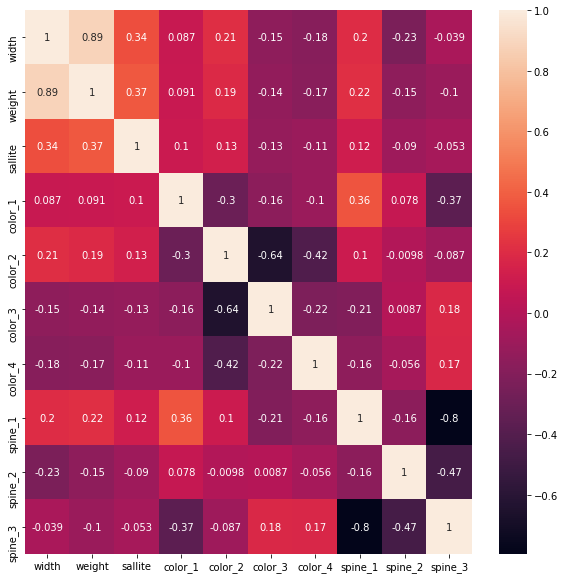

In [0]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

We can see that the number of sallites are positively correlated with the width and weight. So the "stronger" the physical appearance of the female crab, the more likely it is to attract more male crabs. It is no surprise that weight and width are highly correlated with one another.

We can also identify that it seems as if the male crabs prefer light colors (1 and 2) compared to darker colors (3 and 4). 

Also, a good condition of the spine (1) is an indicator for more sallites.

Now, we want to take a closer look at those findings by looking at the regression results.

### Data Partitioning and Scaling

In [0]:
X = df.drop(columns = ['sallite'])
y = df['sallite']

# Apply scaler for pre-processing
scaler = MinMaxScaler()
df[['width', 'weight']] = scaler.fit_transform(df[['width', 'weight']])

# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### Baseline Model

**Baseline model: Poisson Regression**

In [0]:
import statsmodels.api as sm
poisson = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson.summary())

y_pred = poisson.predict(X_test)

# Check accuracy scores for regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                sallite   No. Observations:                  138
Model:                            GLM   Df Residuals:                      130
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -367.01
Date:                Sun, 10 May 2020   Deviance:                       449.87
Time:                        17:24:20   Pearson chi2:                     439.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
width          0.0393      0.054      0.722      0.4

### OLS Regression

In [0]:
import statsmodels.formula.api as sm

data = X_train.join(y_train)
model = sm.ols(formula="sallite ~ width + weight + spine_1 + spine_2 + spine_3 + color_1 + color_2 + color_3 + color_4", data=data).fit()
print(model.summary())

y_pred = model.predict(X_test)

# Check accuracy scores for regression
print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

                            OLS Regression Results                            
Dep. Variable:                sallite   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     3.028
Date:                Sun, 10 May 2020   Prob (F-statistic):            0.00555
Time:                        17:24:25   Log-Likelihood:                -346.07
No. Observations:                 138   AIC:                             708.1
Df Residuals:                     130   BIC:                             731.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6806      3.353     -0.501      0.6

The OLS regression leads to better results than the poisson regression.

In [0]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}) 
results

,Actual,Predicted
162,4,4.212664
42,4,4.109007
90,8,4.755259
60,10,4.484092
114,6,3.242447
137,0,1.957662
41,0,2.687322
15,5,1.861159
113,1,4.325874
108,0,3.417890


After looking at the results of the regresion we can confirm our previous findings that the male crabs prefer condition 1 for the spine as spine_1 has the lowest negative impact on number of sallites and respectiveliy the same for color 1 and 2.

## d.)

d.) Schätzen Sie den Anteil des Rohöls im Test-Datensatz, das in Gasolin konvertiert wird,
anhand anderer Indikatoren im Datensatz gasoline.csv.
Baseline: Beta Regression.

### Read Data

In [0]:
#read dataframe
df = pd.read_csv(basedir+'gasoline.csv')
df.head()

,yield,gravity,pressure,temp10,temp,batch
0,0.122,50.8,8.6,190,205,1
1,0.223,50.8,8.6,190,275,1
2,0.347,50.8,8.6,190,345,1
3,0.457,50.8,8.6,190,407,1
4,0.080,40.8,3.5,210,218,2


### Beta Regression

Since R has the beta regression already implemented, we switch to R for this subtask.

In [0]:
# activate R magic to be able to use R in python notebook
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [0]:
# R cell
%%R
#install.packages("betareg") #neccessary to run first for each session
library(betareg) 

gasoline = read.csv(file = '/content/drive/My Drive/PSDA Group 4/Data/gasoline.csv')

#train test split

## 80% of the sample size
smp_size <- floor(0.8 * nrow(gasoline))

## set the seed to make our partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(gasoline)), size = smp_size)

train <- gasoline[train_ind, ]
test <- gasoline[-train_ind, ]

model_best <- betareg(yield ~ gravity + pressure + temp10 + temp + batch, data = train)
print(mean((test$yield - predict(model_best, test)) ^ 2))

model <- betareg(yield ~ gravity + pressure + temp10 + temp, data = train)
print(mean((test$yield - predict(model, test)) ^ 2))

model <- betareg(yield ~ gravity + pressure + temp10, data = train)
print(mean((test$yield - predict(model, test)) ^ 2))

model <- betareg(yield ~ gravity + pressure + temp10, data = train)
print(mean((test$yield - predict(model, test)) ^ 2))

model <- betareg(formula = yield ~ batch + temp, data = train)
print(mean((test$yield - predict(model, test)) ^ 2))

model <- betareg(formula = yield ~ batch + temp, data = train)
print(mean((test$yield - predict(model, test)) ^ 2))

print('The MSE (Mean Squared Error) of the predictions for the test dataset is the lowest when using the Beta regression model with all predictor variables (gravity, pressure, temp10, temp, batch). A combination of other variables lead to worse performance.\n')
 
print('Predictions for yields for test dataset')
print(predict(model_best, test))


 [1] 31 15 19 14  3 10 18 22 11  5 20 29 23 30  9 28  8 27  7 32 26 17  4  1 24
[1] 0.0005348347
[1] 0.0005419241
[1] 0.008636288
[1] 0.008636288
[1] 0.0006437665
[1] 0.0006437665
[1] "The MSE (Mean Squared Error) of the predictions for the test dataset is the lowest when using the Beta regression model with all predictor variables (gravity, pressure, temp10, temp, batch). A combination of other variables lead to worse performance.\n"
[1] "Predictions for yields for test dataset"
         2          6         12         13         16         21         25 
0.19864916 0.14988249 0.17180945 0.28746822 0.25955364 0.05473993 0.07934364 


### Random Forest Regressor

Now we want to try other models as well.

In [0]:
df = pd.read_csv(basedir+'gasoline.csv')
df.head()

,yield,gravity,pressure,temp10,temp,batch
0,0.122,50.8,8.6,190,205,1
1,0.223,50.8,8.6,190,275,1
2,0.347,50.8,8.6,190,345,1
3,0.457,50.8,8.6,190,407,1
4,0.080,40.8,3.5,210,218,2


In [0]:
y = df['yield']
X = df.drop(columns = ['yield'])

# Apply scaler
scaler = MinMaxScaler()
df[['gravity', 'pressure','temp10','temp']] = scaler.fit_transform(df[['gravity', 'pressure','temp10','temp']])

# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [0]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)) 
results 

Mean Squared Error: 0.0011197245857142882


,Actual,Predicted
11,0.152,0.18023
22,0.161,0.18874
10,0.069,0.09420
2,0.347,0.29739
16,0.349,0.30031
14,0.144,0.16635
28,0.232,0.24947


In this scenario the baseline model is already a very good model, as the MSE is very low. Trying out other models such as a RandomForestRegressor could not achieve better results. Applying some pre-processing (Scaling) improved the Random Forest's performance, but performs still worse than the beta regression.